In [1]:
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Using device: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU. Using CPU.")

GPU is available!
Using device: Tesla T4


In [3]:
!pip install gdown --quiet
!gdown '1nizYa2JQHOj4Wv35DjLfeypUY5dJfE8E'

Downloading...
From (original): https://drive.google.com/uc?id=1nizYa2JQHOj4Wv35DjLfeypUY5dJfE8E
From (redirected): https://drive.google.com/uc?id=1nizYa2JQHOj4Wv35DjLfeypUY5dJfE8E&confirm=t&uuid=d6b0e956-0218-44f1-80c8-cbabccae40f9
To: /content/final_data_with_summarization_FinalTesting1.csv
100% 137M/137M [00:01<00:00, 74.0MB/s]


# 1. Loading the Data

In [4]:
df = pd.read_csv(r"final_data_with_summarization_FinalTesting1.csv")

In [6]:
df['label'] = 1 - df['label'] # flipping labels

In [7]:
df["input"] = df["text_summary"].fillna(df["text"])

In [8]:
df["input"].isnull().sum()

np.int64(0)

In [9]:
X = df["title"].fillna("") + " " + df["input"].fillna("")

In [10]:
Y = df["label"]

In [11]:
X_test = X.values
y_test = Y.values

# 2. Preparing Data Loaders and Model

We use the [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) embedding model from huggingface and fine tune it.

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels.astype("float32")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [14]:
test_dataset = TextDataset(X_test, y_test)

In [15]:
batch_size = 1024

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

In [17]:
class EmbeddingClassifier(nn.Module):
    def __init__(self, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        super(EmbeddingClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.classifier = nn.Sequential(
            nn.Linear(384, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 2)
        )

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
            input_mask_expanded.sum(1), min=1e-9
        )

    def forward(self, input_texts):
        encoded = self.tokenizer(
            input_texts,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(next(self.parameters()).device)

        model_output = self.encoder(**encoded)
        sentence_embeddings = self.mean_pooling(model_output, encoded['attention_mask'])
        logits = self.classifier(sentence_embeddings)
        return logits  # ouput shape: [batchsize, 2]

In [18]:
NN_Model = EmbeddingClassifier()
NN_Model.to(device)

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

EmbeddingClassifier(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elem

In [19]:
NN_Model.load_state_dict(torch.load('EmbeddingClassifier_FineTuned.pth'))

<All keys matched successfully>

# 3. Helper Functions

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
def perform_deep_test_analysis(y_test, test_preds: np.array, test_preds_proba: np.array, model_name: str) -> None:
    """"
    This function takes in a model object and model name, and performs a deep analysis on the model's performance on the test set.
    It prints classification report, confusion matrix, ROC AUC score and plots the ROC curve.
    """
    cm = confusion_matrix(y_test, test_preds)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n")
    print("FOR TESTING SET: ")
    print(classification_report(y_test, test_preds))
    print("\n")

    print(f"ROC AUC Score: {roc_auc_score(y_test, test_preds_proba):.2%}")
    print("\n")

    fpr, tpr, _ = roc_curve(y_test, test_preds_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# 4. Making Predictions

In [22]:
def make_predictions_using_NN(model, data_loader):
    model.eval()
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for xb, labels in tqdm(data_loader):
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())

    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)
    return all_preds, all_probs

In [23]:
test_preds, test_probs_1dCNN = make_predictions_using_NN(NN_Model, test_loader)

100%|██████████| 44/44 [04:16<00:00,  5.84s/it]


In [24]:
print("Test performance")
print(classification_report(y_test, test_preds))

Test performance
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     23481
           1       0.97      1.00      0.98     21417

    accuracy                           0.99     44898
   macro avg       0.98      0.99      0.99     44898
weighted avg       0.99      0.99      0.99     44898



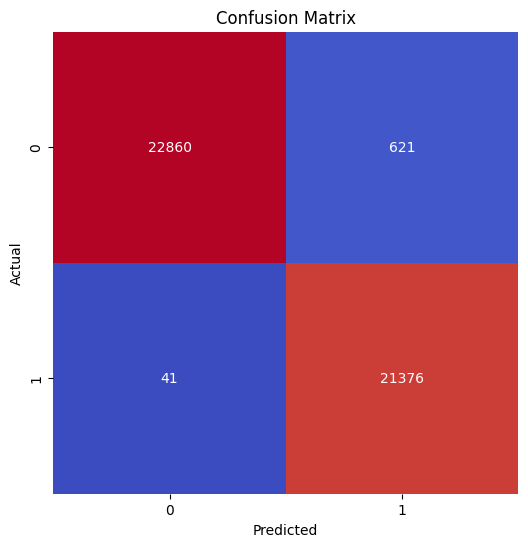



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     23481
           1       0.97      1.00      0.98     21417

    accuracy                           0.99     44898
   macro avg       0.98      0.99      0.99     44898
weighted avg       0.99      0.99      0.99     44898



ROC AUC Score: 99.95%




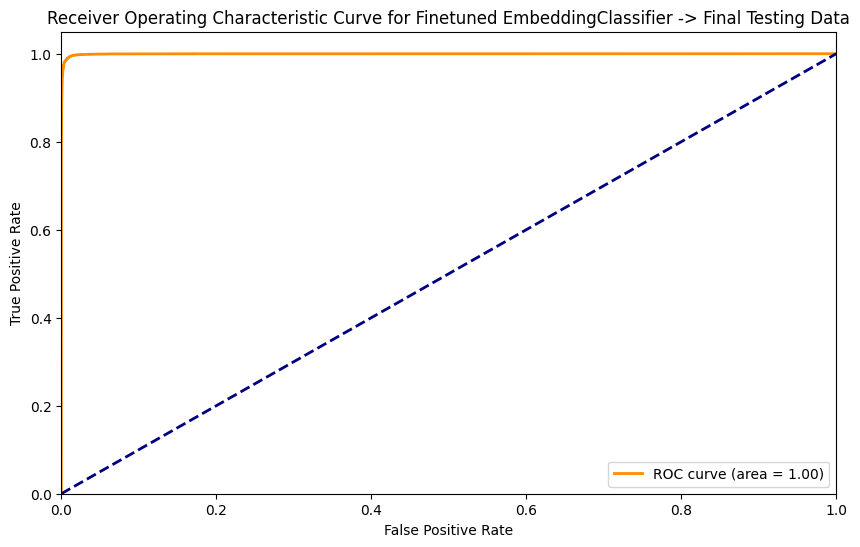

In [25]:
perform_deep_test_analysis(y_test, test_preds, test_probs_1dCNN[:, 1], "Finetuned EmbeddingClassifier -> Final Testing Data")

# XGBoost

In [26]:
model_pretrained = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [27]:
import pickle

with open('XGBoost_Model.pkl', 'rb') as file:
    XGBoost_Model = pickle.load(file)

In [28]:
XGBoost_Model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping=30,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [29]:
def batch_encode(text_list, model, batch_size=2048*3):
    embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size)):
        batch = text_list[i:i+batch_size]
        batch_emb = model.encode(batch)
        embeddings.extend(batch_emb)
    return embeddings

In [30]:
X_test_embeddings = batch_encode(X_test, model_pretrained)

100%|██████████| 8/8 [02:00<00:00, 15.03s/it]


In [31]:
test_preds_XGBOOST = XGBoost_Model.predict(X_test_embeddings)
test_preds_proba_XGBOOST = XGBoost_Model.predict_proba(X_test_embeddings)[:, 1]

In [32]:
print("XGBoost Test")
print(classification_report(y_test, test_preds_XGBOOST))

XGBoost Test
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     23481
           1       0.95      0.98      0.96     21417

    accuracy                           0.96     44898
   macro avg       0.96      0.96      0.96     44898
weighted avg       0.96      0.96      0.96     44898



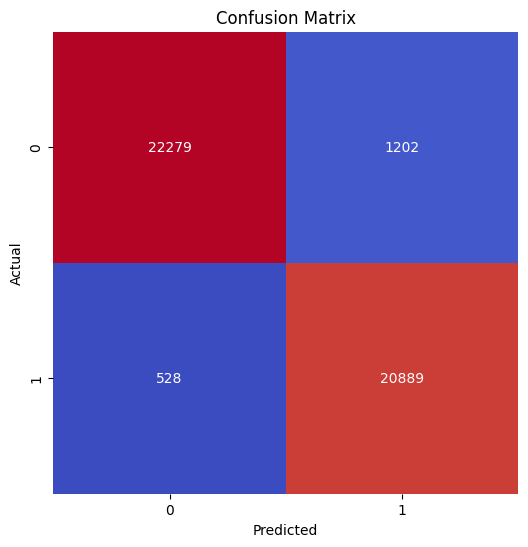



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     23481
           1       0.95      0.98      0.96     21417

    accuracy                           0.96     44898
   macro avg       0.96      0.96      0.96     44898
weighted avg       0.96      0.96      0.96     44898



ROC AUC Score: 96.21%




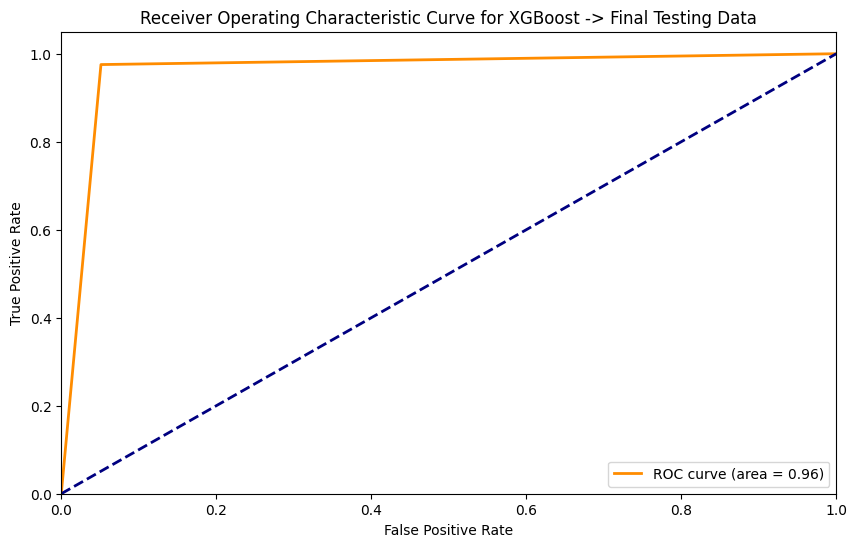

In [34]:
perform_deep_test_analysis(y_test, test_preds_XGBOOST, test_preds_XGBOOST, "XGBoost -> Final Testing Data")